#Descrizione

Modello su database da 37600; rete bidirezionale LSTM (CuDNN).

Eseguito codice 4:

1.   2 layer da 141 nodi, 94 nodi;
2.   Immagini 128x64;
3.   1024 batch size;
4.   Accuratezza finale: 95,7% (con 36k era 96%).

(Patience = 10).


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install PyDrive

#Import

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout

import time
import math

print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Defining methods

In [ ]:
class Stats:

  def __init__( self, img_dim, perc_used, batch_size_used, 
                val_acc, val_loss, total_epochs,
                early_stopping_epochs, total_time, modello, history, _for_conf_matr, model_name):
    
    self.model = modello
    self.history = history

    self._for_conf_matr = _for_conf_matr

    self.img_dim = img_dim           
    self.perc = str(perc_used)
    self.batch_size = str(batch_size_used)
    
    self.val_acc = str(round(val_acc, 5))
    self.val_loss = str(round(val_loss, 5))

    self.total_epochs = str(total_epochs)
    self.early_stopping_epochs = str(early_stopping_epochs)
    self.training_time = str(round(total_time, 5))
    self.model_name = model_name

  def myStats(self):
    print("Dimensione immagini: ", self.img_dim)
    print("Percentuale test set: " + self.perc + "%")
    print("Dimensione batch size: " + self.batch_size)

    print("Val accuracy: " + self.val_acc)
    print("Val loss: " + self.val_loss)

    print("Epoche di addestramento utilizzate: " + self.early_stopping_epochs + "/" + self.total_epochs)
    print("Tempo di addestramento: " + self.training_time + " sec")
    print("Model: " + self.model_name)

In [ ]:
#Extract the class from the file name, if the class is the string before che -
def extract_label(from_string):
  position = from_string.index('-') # gets position of the - in the filename
  substring = from_string[0:position]
  return substring

def extract_obf(from_string):
  start_pos = from_string.index('-')
  end_pos = from_string.index('.')
  substring = from_string[(start_pos + 1):end_pos]
  return substring

def mapping_labels_encoded(label_encoder):
  for index in range(len(list(label_encoder.classes_))):
    print(index, end = "-> ")
    print(list(label_encoder.inverse_transform([index]))) 

class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


print("Done")

Done


#Import database

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1s5Z92N0_UqIsI1xoQewsFmhs2iDGk14F"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data_37600.zip')        # replace the file name with your file

In [ ]:
!unzip -q data_37600.zip -d DB_Repo/

print("Done")

Done


In [ ]:
path, dirs, files = next(os.walk("/content/DB_Repo/data"))
file_count = len(files)
#Should be 37600
print(file_count)

37600


In [ ]:
%cd /content/DB_Repo/data
!pwd

/content/DB_Repo/data
/content/DB_Repo/data


#Lettura database, resize immagini e modello

In [ ]:
def codice_4():

  batch_size = 256

  #Unit in first layer
  num_units1 = 141
  num_units2 = 94

  new_dim = 128
  MAX_LEN = 64 #fisso
  channels = 1

  time_steps = new_dim
  n_features = MAX_LEN
  #size_ts_blocks = 8

  n_epochs = 100

  #Considero il primo 20% della lista di dati come test set
  percentage_required = 20 #%

  #COSTANTI E DICHIARAZIONI

  database_list = list()
  labels_list = list()
  obf_list = list()

  #LETTURA E RESIZE IMMAGINI

  print("START IMAGE INPUT")
  #Aggiungo i valori alle liste leggendo i vari files
  for filename in glob.glob('*.npy'):
    temp_img = np.load(filename)
    temp_img = temp_img.reshape((-1, MAX_LEN)).astype('float32') 
    temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
    database_list.append(temp_img)
    #Salvo la label, ossia la classe
    labels_list.append(extract_label(filename))
    #Salvo la lista di offuscatori di ogni file
    obf_list.append(extract_obf(filename))
  print("END IMAGE INPUT")


  #SHUFFLE

  #Ho i valori e le etichette in due liste (+ obf); 
  #le mescolo mantenendo l'ordine tra valore-label
  temp = list(zip(database_list, labels_list, obf_list))
  np.random.shuffle(temp)
  database_list, labels_list, obf_list = zip(*temp)


  #SUDDIVISIONE DATI

  #Suddivido in training set e test set
  assert len(database_list) == len(labels_list) == len(obf_list)

  index_to_split = math.ceil((len(database_list) * percentage_required) / 100)
  indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

  test_list, training_list = [database_list[s:e+1] for s,e in indices]
  labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
  obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

  #Trasformo i valori in numpy.ndarray
  train_images = np.array(training_list)
  test_images = np.array(test_list)

  train_labels = np.array(labels_training_list)
  test_labels = np.array(labels_test_list)

  train_obf = np.array(obf_training_list)
  test_obf = np.array(obf_test_list)

  label_encoder = LabelEncoder()
  label_encoder.fit(train_labels)
  train_labels_encoded = label_encoder.transform(train_labels)
  test_labels_encoded = label_encoder.transform(test_labels)


  #Normalizzazione valori in range 0-1
  train_images = train_images / 65535.0
  test_images = test_images / 65535.0


  #Dichiarazione parametri

  n_classes = len(list(label_encoder.classes_))

  modelLSTM = ks.Sequential()

  #no activation selection

  modelLSTM.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                              input_shape=(time_steps, n_features)))
  modelLSTM.add(Bidirectional(CuDNNLSTM(num_units2, unit_forget_bias='true')))
  modelLSTM.add(Dense(n_classes, activation='softmax'))

  modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Validation_data è usato al termine di ogni epoch;
  #Batch size should be (at most) the same number of hidden cells
  es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                  mode='auto', restore_best_weights=True, verbose=1)
  time_callback = TimeHistory()

  hist = modelLSTM.fit(train_images, train_labels_encoded, 
                      batch_size = batch_size,
                      validation_data=(test_images, test_labels_encoded), 
                      epochs=n_epochs, shuffle='true',
                      callbacks=[time_callback, es], verbose=1)

  number_of_epochs_it_ran = len(hist.history['loss'])

  time_per_epoch = time_callback.times
  total_time = sum(time_per_epoch)

  test_accuracy = modelLSTM.evaluate(test_images, test_labels_encoded)

  _for_conf_matr = (label_encoder.classes_, test_images, test_labels_encoded)
  statistiche_modello = Stats(train_images[0].shape, percentage_required, batch_size, test_accuracy[1], test_accuracy[0], n_epochs, number_of_epochs_it_ran, total_time, modelLSTM, hist, _for_conf_matr, "model1_bi")

  return statistiche_modello

In [ ]:
results = list()

results.append(codice_4())

START IMAGE INPUT
END IMAGE INPUT
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 30080 samples, validate on 7520 samples
Epoch 1/100
30080/30080 [==============================] - 28s 931us/sample - loss: 2.9342 - acc: 0.2291 - val_loss: 2.2163 - val_acc: 0.3928
Epoch 2/100
30080/30080 [==============================] - 8s 281us/sample - loss: 1.9802 - acc: 0.4583 - val_loss: 1.7240 - val_acc: 0.5197
Epoch 3/100
30080/30080 [==============================] - 8s 281us/sample - loss: 1.4753 - acc: 0.6015 - val_loss: 1.3427 - val_acc: 0.6354
Epoch 4/100
30080/30080 [==============================] -

#Risultati

Dimensione immagini:  (128, 64)
Percentuale test set: 20%
Dimensione batch size: 256
Val accuracy: 0.95745
Val loss: 0.25516
Epoche di addestramento utilizzate: 45/100
Tempo di addestramento: 398.43303 sec
Model: model1_bi


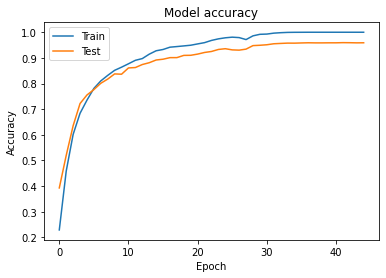

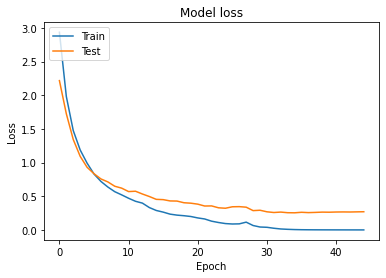

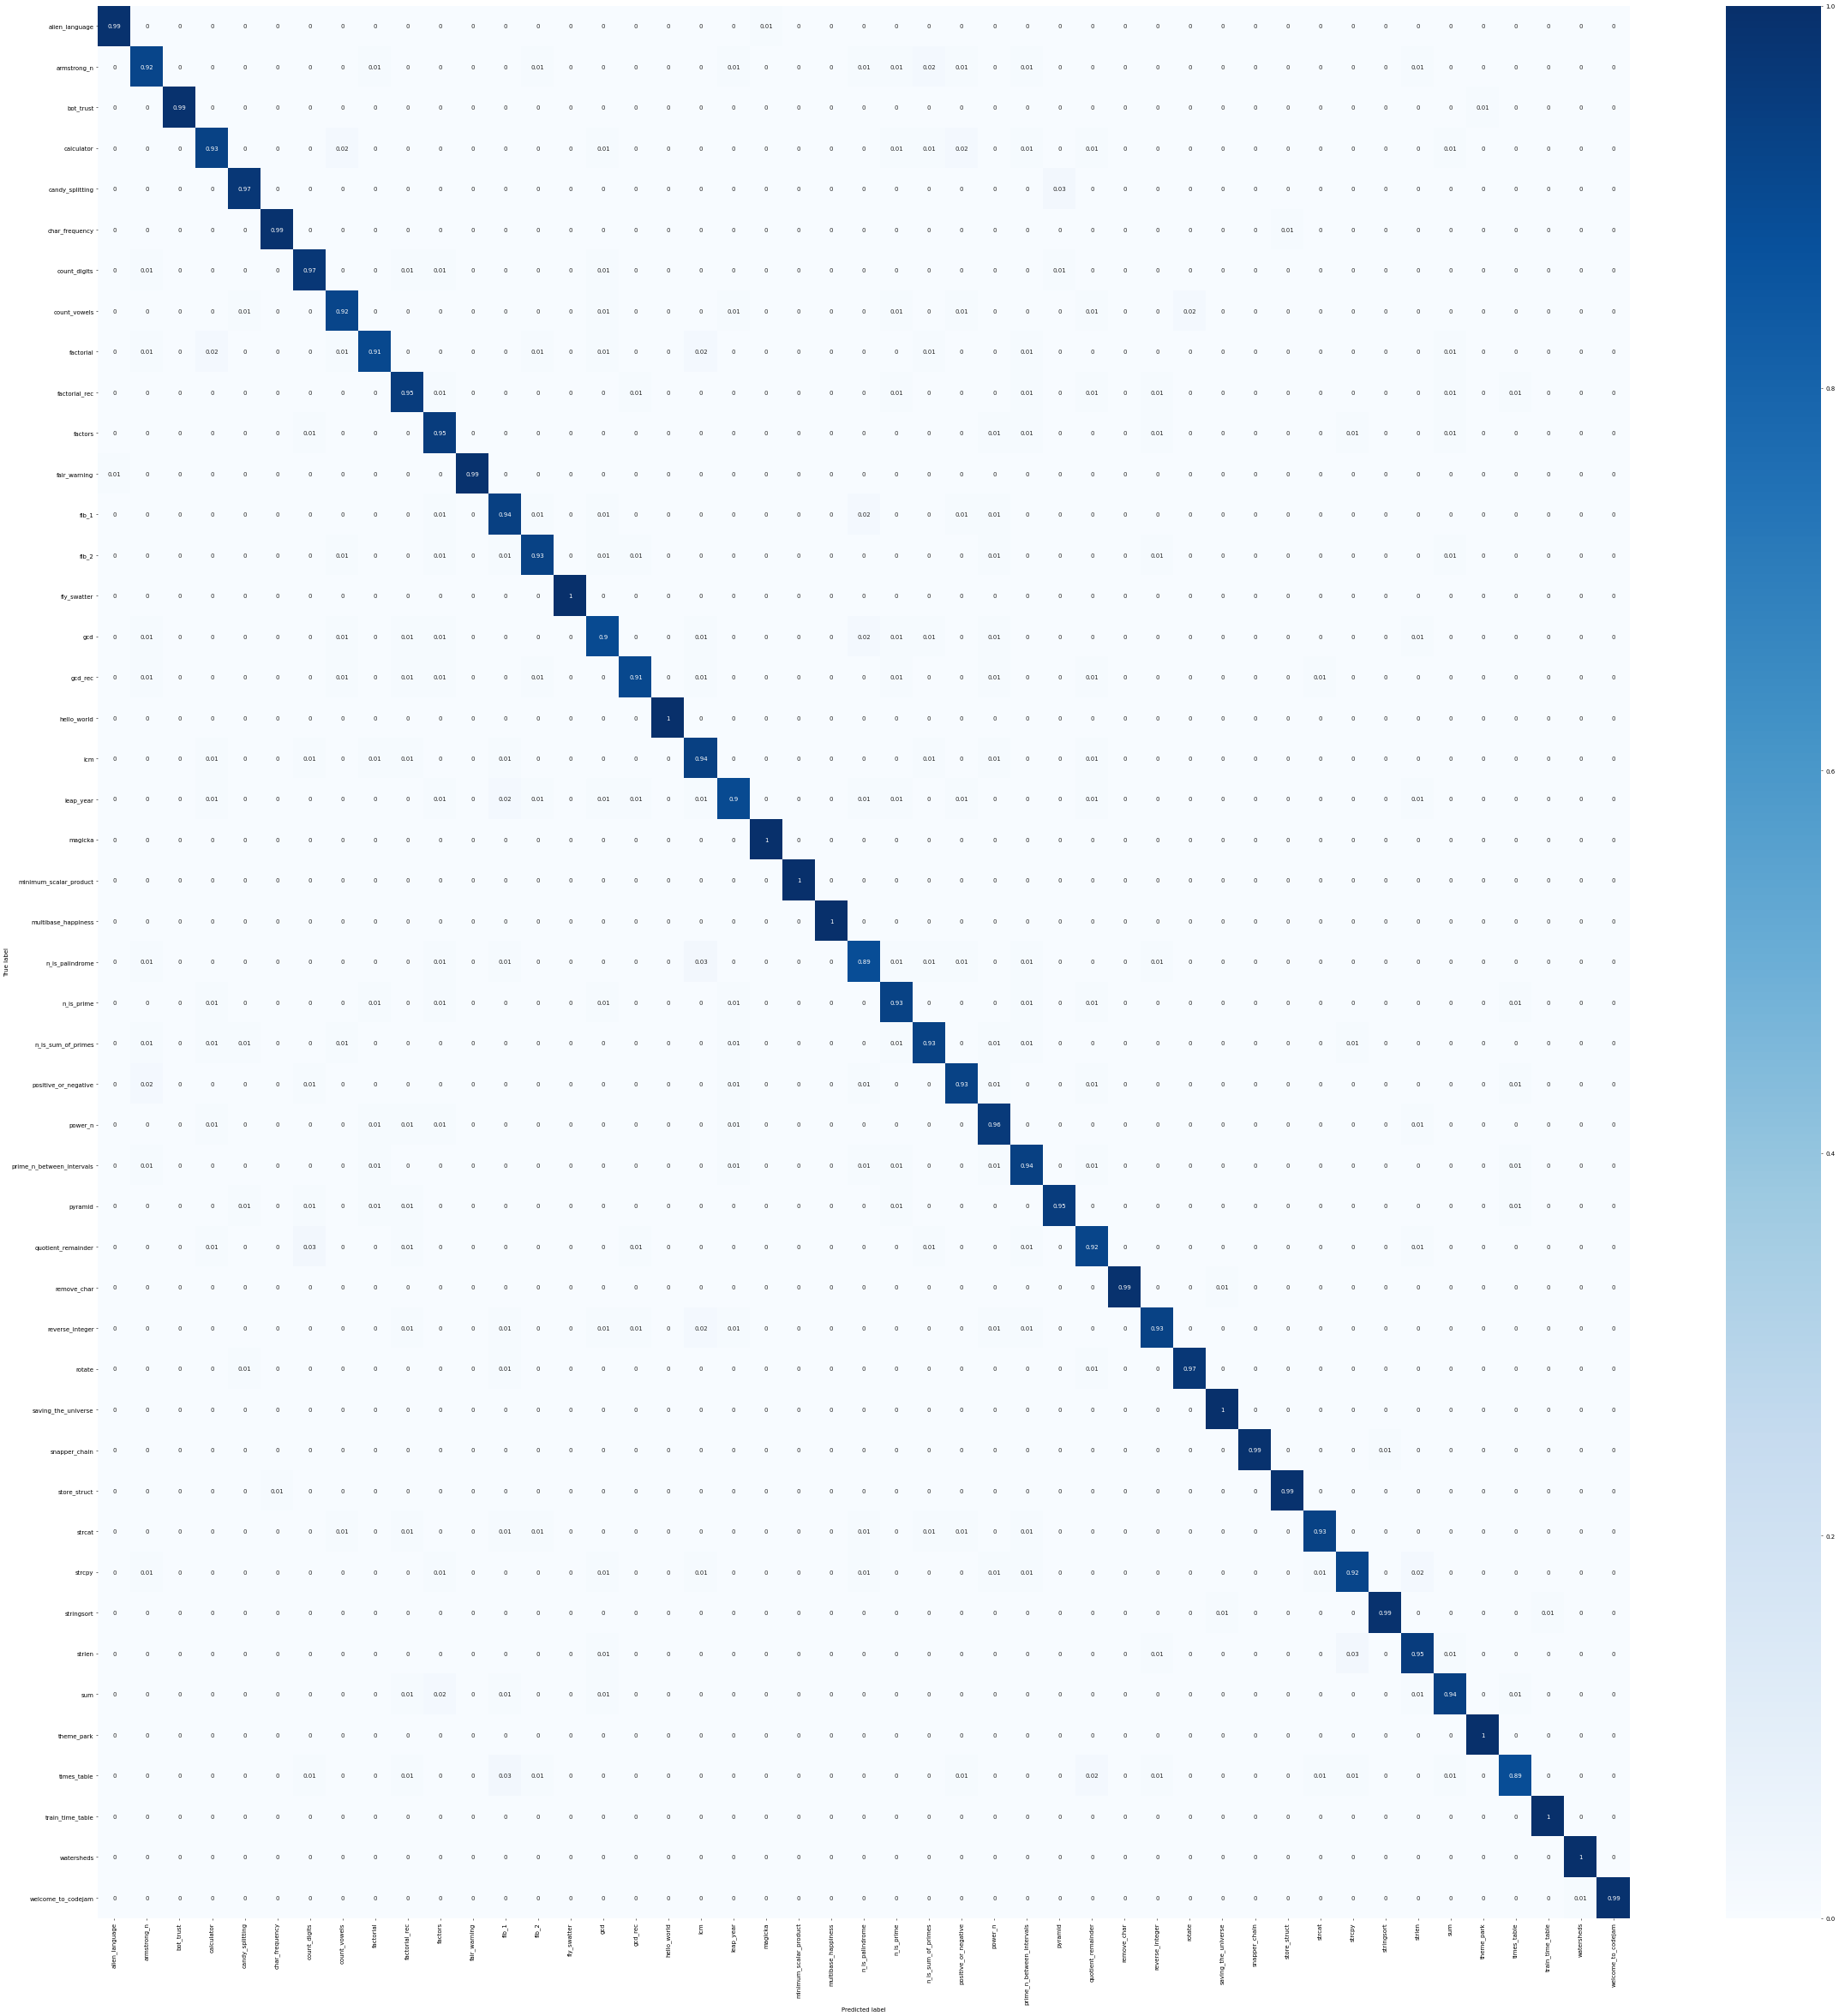

In [ ]:
for elem in results:
  elem.myStats()
  #Plot training & validation accuracy values
  hist = elem.history
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  #Necessito di un array con tutte le labels

  modello = elem.model
  classi, test_images, test_labels_encoded = elem._for_conf_matr
  test_predictions = modello.predict_classes(test_images)

  conf_matr = confusion_matrix(y_true = test_labels_encoded, y_pred = test_predictions)
  #print(conf_matr)

  con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                          index = list(classi), 
                          columns = list(classi))
  
  figure = plt.figure(figsize=(len(list(classi)), len(list(classi))), dpi=50)
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()